In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

In [4]:
df = pd.read_csv('clouds_subset.csv')
print(f"Dataset size: {len(df)} images")
print("Columns:", df.columns.tolist())

FileNotFoundError: [Errno 2] No such file or directory: 'clouds_subset.csv'

In [ ]:
class CloudDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.cloud_types = self.df.columns[1:-1].tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['local_path']
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        label_values = []
        for cloud_type in self.cloud_types:
            val = row[cloud_type]
            try:
                label_values.append(float(val))
            except (ValueError, TypeError):
                label_values.append(0.0)

        labels = torch.tensor(label_values, dtype=torch.float32)
        return image, labels

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train: {len(train_df)}, Test: {len(test_df)}")

train_dataset = CloudDataset(train_df, transform=transform)
test_dataset = CloudDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.cloud_types)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
print(f"Using device: {device}")

In [ ]:
model.train()
for epoch in range(5):
    epoch_loss = 0
    num_batches = 0

    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/5')

    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

        train_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1}/5 completed, avg loss: {avg_loss:.4f}")
    print()

Epoch 1/5: 100%|███████████████████| 50/50 [01:30<00:00,  1.82s/it, loss=0.4279]


Epoch 1/5 completed, avg loss: 0.5511



Epoch 2/5: 100%|███████████████████| 50/50 [01:33<00:00,  1.88s/it, loss=0.3808]


Epoch 2/5 completed, avg loss: 0.3513



Epoch 3/5: 100%|███████████████████| 50/50 [01:31<00:00,  1.82s/it, loss=0.2356]


Epoch 3/5 completed, avg loss: 0.2584



Epoch 4/5: 100%|███████████████████| 50/50 [01:31<00:00,  1.83s/it, loss=0.1523]


Epoch 4/5 completed, avg loss: 0.1771



Epoch 5/5: 100%|███████████████████| 50/50 [01:30<00:00,  1.81s/it, loss=0.1280]

Epoch 5/5 completed, avg loss: 0.1181



In [ ]:
model.eval()
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predictions = torch.sigmoid(outputs) > 0.5

        exact_matches = (predictions == labels).all(dim=1).sum().item()
        correct_predictions += exact_matches
        total_samples += labels.size(0)

accuracy = correct_predictions / total_samples
print(f"\nTest accuracy (exact match): {accuracy:.4f}")


Test accuracy (exact match): 0.2150


In [ ]:
torch.save(model.state_dict(), 'cloud_model.pth')

Model saved as 'cloud_model.pth'


In [ ]:
def predict_image(image_path):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.sigmoid(output)[0]
        predictions = (probabilities > 0.5).cpu().numpy()

    cloud_types = train_dataset.cloud_types
    predicted_types = [cloud_types[i] for i, pred in enumerate(predictions) if pred]

    print(f"Predicted cloud types: {predicted_types}")
    return predicted_types

predict_image('cloud_images/cloud_0.jpg')

Predicted cloud types: ['altocumulus', 'altostratus', 'cumulus', 'stratus']


['altocumulus', 'altostratus', 'cumulus', 'stratus']

In [ ]:
val_df = pd.read_csv('clouds_val.csv')
print(f"Dataset size: {len(val_df)} images")
print("Columns:", val_df.columns.tolist())

val_dataset = CloudDataset(val_df, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model.eval()
val_correct = 0
val_total = 0
val_loss = 0

with torch.no_grad():
    val_bar = tqdm(val_loader, desc='Validating')
    all_preds = []
    all_labels = []

    for images, labels in val_bar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        predictions = torch.sigmoid(outputs) > 0.5

        all_preds.append(predictions.cpu())
        all_labels.append(labels.cpu())

        exact_matches = (predictions == labels).all(dim=1).sum().item()
        val_correct += exact_matches
        val_total += labels.size(0)

        val_bar.set_postfix({'val_acc': f'{val_correct/val_total:.4f}'})

val_accuracy = val_correct / val_total
avg_val_loss = val_loss / len(val_loader)
print(f"\nValidation Results:")
print(f"  Accuracy (exact match): {val_accuracy:.4f}")
print(f"  Average loss: {avg_val_loss:.4f}")
print(f"  Correct predictions: {val_correct}/{val_total}")

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

print(f"\nPer-label accuracy:")
for i, cloud_type in enumerate(val_dataset.cloud_types):
    correct = (all_preds[:, i] == all_labels[:, i]).sum().item()
    total = len(all_labels)
    print(f"  {cloud_type}: {correct/total:.3f}")

Dataset size: 1000 images
Columns: ['photo_url', 'altocumulus', 'altostratus', 'cirrocumulus', 'cirrostratus', 'cirrus', 'cumulonimbus', 'cumulus', 'nimbostratus', 'stratocumulus', 'stratus', 'local_path']
2000


Validating: 100%|███████████████| 32/32 [00:30<00:00,  1.04it/s, val_acc=0.0790]


Validation Results:
  Accuracy (exact match): 0.0790
  Average loss: 0.5966
  Correct predictions: 79/1000

Per-label accuracy:
  altocumulus: 0.596
  altostratus: 0.772
  cirrocumulus: 0.748
  cirrostratus: 0.781
  cirrus: 0.738
  cumulonimbus: 0.873
  cumulus: 0.598
  nimbostratus: 0.848
  stratocumulus: 0.722
  stratus: 0.926


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

all_preds = all_preds.numpy()
all_labels = all_labels.numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

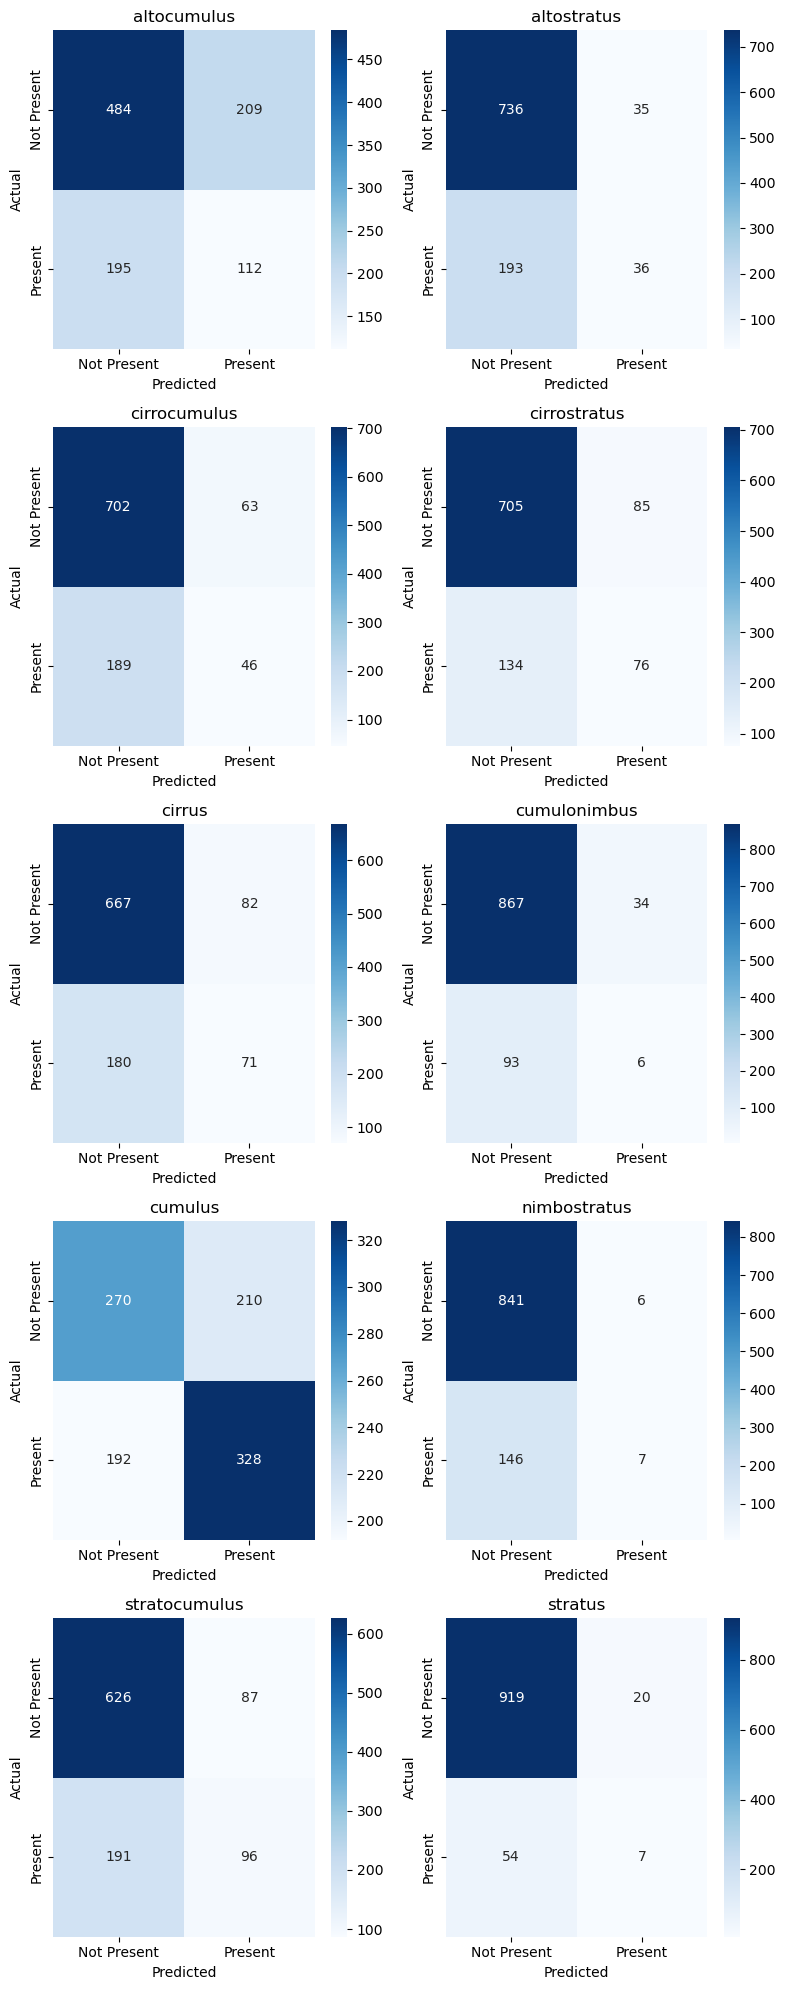

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(8, 20))
axes = axes.flatten()

for i, cloud_type in enumerate(val_dataset.cloud_types):
    true_labels = all_labels[:, i]
    pred_labels = all_preds[:, i]

    cm = confusion_matrix(true_labels, pred_labels)

    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap="Blues",
                xticklabels=['Not Present', 'Present'],
                yticklabels=['Not Present', 'Present'])
    axes[i].set_title(f'{cloud_type}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()